<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/HWK_labs_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes for Jacopo:


 <br>


Define the module path + import packages

In [ ]:
kernel=input('Choose a kernel to use...are you running in local? Y/N')

Choose a kernel to use...are you running in local? Y/Nmnm


In [ ]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/HWK'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from HWK_package.functions import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 368 (delta 23), reused 15 (delta 7), pack-reused 320
Receiving objects: 100% (368/368), 26.34 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Mounted at /content/drive


# Create Grid of Parameters and Simulated expected values.

In [ ]:
import numpy as np
import pandas as pd

# Lista dei parametri
lambda_grid =  np.concatenate(([0.00001,0.005],np.arange(1, 100,1 ), np.arange(100, 600,10 )))
alpha_grid  =  np.concatenate(([0.0001,0.1,0.5],np.arange(1, 10,1), np.arange(10, 60,10)))
beta_grid   =    np.arange(100, 101,1)

# Definizione della funzione da ottimizzare
def function_to_optimize(l, alpha,beta):
    𝛉 = np.array([l,alpha,beta ])
    simulazioni_su_thread = []
    for i in (range(1000)):
        simulazione_su_thread = exp_simulate_by_composition_alt(𝛉, 1)
        simulazioni_su_thread.append(len(simulazione_su_thread))
    return np.mean(simulazioni_su_thread),np.std(simulazioni_su_thread),simulazioni_su_thread


# Lista per memorizzare i risultati
results = []

# Esecuzione della grid search
for l in tqdm(lambda_grid):
    for alpha in alpha_grid:
      for beta in beta_grid:
        sd_expected_value=function_to_optimize(l, alpha,beta)[1]
        mu_expected_value = (function_to_optimize(l, alpha,beta)[0])
        results.append({'lambda': l, 'alpha': alpha,'beta':beta, 'mu_expected_value': mu_expected_value,'sd_exepected_value':sd_expected_value})
# Creazione del DataFrame
df = pd.DataFrame(results)

# Salvataggio del DataFrame su file CSV
df.to_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv', index=False)

# Stampare il DataFrame
print(df)

100%|██████████| 151/151 [01:32<00:00,  1.63it/s]

         lambda    alpha  beta  mu_expected_value  sd_exepected_value
0       0.00001   0.0001   100              0.000            0.000000
1       0.00001   0.1000   100              0.001            0.031607
2       0.00001   0.5000   100              0.004            0.031607
3       0.00001   1.0000   100              0.011            0.089084
4       0.00001   2.0000   100              0.019            0.176986
...         ...      ...   ...                ...                 ...
2562  590.00000  10.0000   100            654.548           28.116301
2563  590.00000  20.0000   100            735.433           34.304122
2564  590.00000  30.0000   100            839.248           42.472500
2565  590.00000  40.0000   100            978.281           50.631678
2566  590.00000  50.0000   100           1166.170           68.964153

[2567 rows x 5 columns]


# Simulate collective behavior

We are simulating the collective behaviour of a group of user staring from the individual commenting process.
Since the variability of the process is huge, and we are dealing with an irregular time span, is important to regulate as follow the data by thread:

Fix a value for **alpha** and a value for **beta**

1.   Ignore users with less than 3 comments.
2.   Identify the timestamp of the first comment the thread, and the  last one.
3.   Model the remaining N-2 comments using an Hawkes Process, knowing that the expected values is N-2, choose lambda in ordet to obtain it. To do it consult the grid search table.
4.   Simulate with a suitable triplette of parameters (given alpha and beta).
5.   Calculate the Kolmogorov-Smirnov statistic of difference among ECDF and  SCDF.







### Read data:


*   Grid for parameters' choice
*   Dataset of Voat



In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import kstest
grid_search_results=pd.read_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv')
dataset = pd.read_parquet(source_data)

### Check Grid of parameters

In [ ]:

reachable_values_with_alpha={}
for alpha in grid_search_results.alpha.unique():
  grid_search_results_filtered=grid_search_results[grid_search_results['alpha']==alpha]
  unique_rounded_values = grid_search_results_filtered['mu_expected_value'].round().unique()
  unique_rounded_values.sort()
  reachable_values_with_alpha[alpha]=[unique_rounded_values.min(),unique_rounded_values.max()]

reachable_values_with_alpha

{0.0001: [0.0, 590.0],
 0.1: [0.0, 591.0],
 0.5: [0.0, 592.0],
 1.0: [0.0, 597.0],
 2.0: [0.0, 602.0],
 3.0: [0.0, 608.0],
 4.0: [0.0, 615.0],
 5.0: [0.0, 621.0],
 6.0: [0.0, 626.0],
 7.0: [0.0, 632.0],
 8.0: [0.0, 641.0],
 9.0: [0.0, 647.0],
 10.0: [0.0, 655.0],
 20.0: [0.0, 735.0],
 30.0: [0.0, 839.0],
 40.0: [1.0, 978.0],
 50.0: [1.0, 1166.0]}

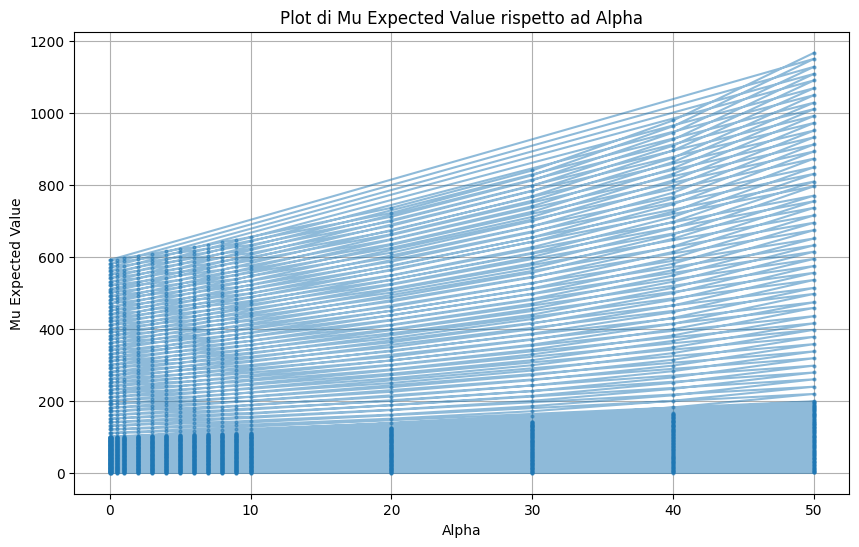

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che grid_search_results sia il tuo DataFrame

# Creare il plot
plt.figure(figsize=(10, 6))  # Imposta le dimensioni del plot

# Plot
plt.plot(grid_search_results['alpha'], grid_search_results['mu_expected_value'], marker='o', linestyle='-',alpha=0.5,markersize=2)

# Aggiungi etichette e titolo
plt.xlabel('Alpha')
plt.ylabel('Mu Expected Value')
plt.title('Plot di Mu Expected Value rispetto ad Alpha')

# Mostra il plot
plt.grid(True)  # Aggiunge una griglia
plt.show()


### Simulate and compare Root by Root
Simulate and compare results of fitting using different values of alpha:

**[0.001, 10, 20, 30, 40, 50]**




In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kstest
from tqdm import tqdm

# Get the roots with submission counts greater than 250
root_submission_counts = dataset.root_submission.value_counts().reset_index()
selected_roots = list(root_submission_counts[root_submission_counts['count'] > 250]['root_submission'])

# Load the old data
old_data = pd.read_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv')
old_data = old_data.drop(old_data.index)

# Initialize parameters
x_values = np.arange(0, 1, 0.0001)
mean_ks_values = []
std_ks_values = []
alpha_values = []
roots_column = []
beta_value = 60

# Iterate over different alpha values
for alpha_value in tqdm([0.05, 10, 20, 30, 40, 50]):
    ks_values = []

    # Iterate over selected roots
    for root_value in tqdm(selected_roots):
        # Repeat the process 10 times
        for _ in range(30):
            # Check if data for the alpha and root combination is not already present
            if len(old_data[(old_data['Alpha'] == alpha_value) & (old_data['Root'] == root_value)]) == 0:
                # Simulate Hawkes collective behavior
                ℋ_t, ℋ_t_simulated = simulate_hawkes_collective_behaviour(root_value, dataset, alpha_value, beta_value, grid_search_results)

                # Calculate cumulative series and simulated cumulative series
                cumulative_series = F(x_values, ℋ_t)
                cumulative_series_simulated = F(x_values, ℋ_t_simulated)

                # Calculate KS statistic
                ks_statistic, _ = kstest(cumulative_series, cumulative_series_simulated)
                ks_values.append(ks_statistic)
                mean_ks_values.append(np.mean(ks_values))
                std_ks_values.append(np.std(ks_values))
                alpha_values.append(alpha_value)
                roots_column.append(root_value)

# Create a new DataFrame with the updated values
new_data = pd.DataFrame({
    'Alpha': alpha_values,
    'Beta': beta_value,
    'Mean_KS': mean_ks_values,
    'Std_KS': std_ks_values,
    'Root': roots_column
})

# Concatenate the old and new DataFrames, drop duplicates, and save to CSV
concatenated_df = pd.concat([old_data, new_data])
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df = concatenated_df.drop_duplicates(subset=["Alpha", "Beta", "Root"])
concatenated_df.to_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv', index=False)


As a result, we have for each thread the mean and the sd  of KS differnce among ECDF and SCDF. So we can decide if on average, on all the conversation what is the best fitting model.

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv')

# Numero di campioni da generare per ciascuna riga
num_samples = 10000

# Creazione di un array vuoto per memorizzare tutti i campioni generati
samples = []

# Generazione dei campioni per ciascuna riga
for index, row in df.iterrows():
    mean = row['Mean_KS']
    sd = row['Std_KS']
    sample = np.random.normal(loc=mean, scale=sd, size=num_samples)
    samples.append(sample)

# Creazione del boxplot
plt.boxplot(samples, labels=df.Alpha)
plt.xlabel('Riga')
plt.ylabel('Valore')
plt.title('Confronto delle distribuzioni normali per riga')
plt.show()

,Alpha,Beta,Mean_KS,Std_KS,Root
0,0.0001,100,0.1515,0.0,all
1,0.1000,100,0.1515,0.0,all
2,0.5000,100,0.1515,0.0,all
3,1.0000,100,0.1515,0.0,all
4,2.0000,100,0.1935,0.0,all
5,3.0000,100,0.1988,0.0,all
6,4.0000,100,0.1591,0.0,all
7,5.0000,100,0.1281,0.0,all
8,6.0000,100,0.1667,0.0,all
9,7.0000,100,0.2152,0.0,all
